# Mini project 1: Where do I fly next?
___



## Step1 - Webscraping

In [ ]:
!pip install selenium
!pip install webdriver-manager
!pip install selenium-stealth
!apt install chromium-chromedriver

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.2/400.2 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.7 MB/s eta 0:00:00


In [ ]:
from selenium import webdriver
from selenium_stealth import stealth
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
import random

# create ChromeOptions object
# all the following settings are mandatory for the driver to run on colab
options = webdriver.ChromeOptions()

#run in headless mode
options.add_argument("--headless")

# disable the AutomationControlled feature of Blink rendering engine
options.add_argument('--disable-blink-features=AutomationControlled')

# disable pop-up blocking
options.add_argument('--disable-popup-blocking')

# start the browser window in maximized mode
options.add_argument('--start-maximized')

# disable extensions
options.add_argument('--disable-extensions')

# disable sandbox mode
options.add_argument('--no-sandbox')

# disable shared memory usage
options.add_argument('--disable-dev-shm-usage')

user_agents = [
    # Google Chrome User-Agents
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",

    # Mozilla Firefox User-Agents
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:89.0) Gecko/20100101 Firefox/89.0",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:89.0) Gecko/20100101 Firefox/89.0",

    # Safari User-Agent
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.0 Safari/605.1.15",

    # Internet Explorer User-Agents
    "Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; AS; rv:11.0) like Gecko",
    "Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7.0; AS; rv:11.0) like Gecko",

    # Microsoft Edge User-Agents
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36 Edg/91.0.864.59",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36 Edg/91.0.864.59",

    # Opera User-Agent
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/91.0.4472.124 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36 OPR/76.0.4017.123",
]

user_agent = random.choice(user_agents)
options.add_argument(f'user-agent={user_agent}')

# create a new Chrome webdriver instance, passing in the Service and options objects
driver = webdriver.Chrome(options=options)
driver.execute_script("Object.defineProperty(navigator, 'webdriver', {get: () => undefined})")

In [ ]:
# setup the selenium-stealth
stealth(driver,
        languages=["en-US", "en"],
        vendor="Google Inc.",
        platform="MacIntel",
        webgl_vendor="Intel Inc.",
        renderer="Intel Iris OpenGL Engine",
        fix_hairline=True,
        )

### Scraping momondo.com for flights from HEL to CDG on 25.10.2023

In [ ]:
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException
import time
# navigate to the webpage
url = f'https://www.momondo.com/flight-search/HEL-CDG/2023-10-25?sort=bestflight_a&fs=virtualinterline=-virtualinterline'
driver.get(url)
# wait until the cards appear on the DOM
WebDriverWait(driver, 20).until(lambda driver: driver.execute_script('return document.readyState') == 'complete')
try:
    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, 'bBPb-close')))
    driver.find_element(By.CLASS_NAME, 'bBPb-close').click()
    print('Closed the notification pop-up')
except Exception as e:
  print("Didn't find the notification pop-up")
try:
  WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, 'ClLW-upgrade-browser-msg')))
  driver.find_element(By.CLASS_NAME, 'ClLW-upgrade-browser-msg').click()
  print('Closed the upgrade browser pop-up')
except Exception as e:
  print("Didn't find the upgrade browser pop-up")

In [ ]:
import re

def proc_card_momondo(card):
  layovers, n_stops, duration, departure, arrival, carriers, aircrafts, price = (
      [], -1, '-1m', 'NA', 'NA', [], [],'$-1')
  try:
    card.find_element(By.CLASS_NAME, 'nrc6-content-section').click()
    WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CLASS_NAME, 'P-pu-footer-pqf')))
    stops = card.find_element(By.CLASS_NAME, 'JWEO-stops-text')
    matched = re.search(r'\d+', stops.text)
    n_stops = matched.group() if matched else 0

    duration = card.find_element(By.CSS_SELECTOR, '.xdW8 .vmXl').text

    time = card.find_element(By.CSS_SELECTOR, '.VY2U .vmXl').text.split('–')
    departure = time[0]
    arrival = time[1]

    carriers = card.find_element(By.CSS_SELECTOR, '.VY2U .c_cgF').text.split(', ')
    # aircrafts = [e.text for e in aircrafts_info]

    price = card.find_element(By.CLASS_NAME, 'f8F1-price-text').text

    layovers_info = card.find_elements(By.CLASS_NAME, 'c62AT-layover-info')
    pattern = r'(\d+h) (\d+m)•(.*)\((\w+)\)'
    layovers = [re.sub(pattern, r'\1\2•\4', e.text) for e in layovers_info]

    aircrafts_info = card.find_elements(By.CLASS_NAME, 'af2q-equip-name')
    aircrafts = [e.text for e in aircrafts_info]

    card.find_element(By.CLASS_NAME, 'nrc6-content-section').click()
  except Exception as e:
    print(f'Exception: {e}')
  return [layovers, n_stops, duration, departure, arrival, carriers, aircrafts, price]

In [ ]:
try:
  WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CLASS_NAME, 'bBPb-close')))
  driver.find_element(By.CLASS_NAME, 'bBPb-close').click()
  print('Closed the rating pop-up')
except Exception as e:
  print("Didn't find the rating pop-up")

for _ in range(5):
  try:
      # Find and click the "Show more flights" button
      show_more = WebDriverWait(driver, 20).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, "[class='ULvh-button show-more-button']"))
      )
      show_more.click()
      driver.execute_script("window.scrollBy(0, -3000);")
  except Exception as e:
      print(f'Exception while clicking show more: {e}')

In [ ]:
import csv
from google.colab import drive
drive.mount('/content/drive')

info_rows_momondo = []
try:
  cards = driver.find_elements(By.CLASS_NAME, 'nrc6')
  print(f'Total cards: {len(cards)}')
  print(f'Parsing cards..')
  i = 1
  for card in cards:
    print(f'Card {i}/{len(cards)}')
    parsed_card_info = proc_card_momondo(card)
    parsed_card_info.append('momondo')
    info_rows_momondo.append(parsed_card_info)
    i += 1
except Exception as e:
    print(f"An error occurred while parsing: {e}")


with open('/content/drive/MyDrive/Colab Notebooks/Flights_final.csv', 'w') as csv_file:
  csv_writer = csv.writer(csv_file)
  csv_writer.writerow(['layover', 'stops', 'duration', 'departure', 'arrival', 'carriers', 'aircrafts', 'price', 'site']) # Header row
  csv_writer.writerows(info_rows_momondo)
  print(f'Rows written: {len(info_rows_momondo)}')


In [ ]:
info_rows_momondo

### Scraping kayak.com for flights from HEL to CDG on 25.10.2023

In [ ]:
# navigate to the webpage
url = f'https://www.kayak.com/flights/HEL-CDG/2023-10-25?sort=bestflight_a&fs=virtualinterline=-virtualinterline'
driver.get(url)
# wait until the cards appear on the DOM
WebDriverWait(driver, 20).until(lambda driver: driver.execute_script('return document.readyState') == 'complete')
try:
    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, 'bBPb-close')))
    driver.find_element(By.CLASS_NAME, 'bBPb-close').click()
    print('Closed the notification pop-up')
except Exception as e:
  print("Didn't find the notification pop-up")
try:
  WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, 'ClLW-upgrade-browser-msg')))
  driver.find_element(By.CLASS_NAME, 'ClLW-upgrade-browser-msg').click()
  print('Closed the upgrade browser pop-up')
except Exception as e:
  print("Didn't find the upgrade browser pop-up")

In [ ]:
try:
  WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CLASS_NAME, 'bBPb-close')))
  driver.find_element(By.CLASS_NAME, 'bBPb-close').click()
  print('Closed the rating pop-up')
except Exception as e:
  print("Didn't find the rating pop-up")

for _ in range(5):
  try:
      # Find and click the "Show more flights" button
      show_more = WebDriverWait(driver, 20).until(
      EC.presence_of_element_located((By.CSS_SELECTOR, "[class='ULvh-button show-more-button']"))
      )
      show_more.click()
      driver.execute_script("window.scrollBy(0, -3000);")
  except Exception as e:
      print(f'Exception while clicking show more: {e}')

In [ ]:
driver.save_screenshot('f.png')

In [ ]:
info_rows_kayak = []
try:
  cards = driver.find_elements(By.CLASS_NAME, 'nrc6')
  print(f'Total cards: {len(cards)}')
  i = 1
  for card in cards:
    print(f'Card {i}/{len(cards)}')
    i += 1
    parsed_card_info = proc_card_momondo(card)
    parsed_card_info.append('kayak')
    info_rows_kayak.append(parsed_card_info)
except Exception as e:
    print(f"An error occurred while parsing: {e}")

with open('/content/drive/MyDrive/Colab Notebooks/Flights_final.csv', 'a') as csv_file:
  csv_writer = csv.writer(csv_file)
  csv_writer.writerows(info_rows_kayak)
  print(f'Rows written: {len(info_rows_kayak)}')

In [ ]:
info_rows_kayak

### Scraping booking.com for flights from HEL to CDG on 25.10.2023

In [ ]:
def visit_page(page):
  # navigate to the webpage
  url = f'https://flights.booking.com/flights/HEL.AIRPORT-CDG.AIRPORT/?type=ONEWAY&adults=1&cabinClass=ECONOMY&children=&from=HEL.AIRPORT&to=CDG.AIRPORT&fromCountry=FI&toCountry=FR&fromLocationName=Helsinki-Vantaa+Airport&toLocationName=Paris+-+Charles+de+Gaulle+Airport&depart=2023-10-25&sort=BEST&travelPurpose=leisure&aid=304142&label=gen173nr-1FCBkoggI46AdIM1gEaEiIAQGYAQm4ARnIAQzYAQHoAQH4AQKIAgGoAgO4Aq_QpqgGwAIB0gIkMzdmODA3NWItNmQ1Mi00YTFmLTg0YTAtZDYwNzI3MjIxY2Jl2AIF4AIB&page={page}'
  driver.get(url)
  # wait until the cards appear on the DOM
  WebDriverWait(driver, 60).until(EC.presence_of_element_located((By.ID, "flight-card-0")))

  # close cookies pop-up, if any
  try:
    decline_cookies = driver.find_element(By.ID, 'onetrust-reject-all-handler')
    decline_cookies.click()
    print(f"Declined cookies.")
  except NoSuchElementException as e:
    print(f"Cookies pop-up didn't appear.")

  # close the info about search result ordering, this sometimes conflicts with the card close btn
  try:
    info_close = driver.find_element(By.CSS_SELECTOR, 'button[aria-label="Close"][type="button"]')
    info_close.click()
    print("Closed info.")
  except NoSuchElementException as e:
    print(f"Info card didn't appear.")

In [ ]:
import re
import time
from selenium.common.exceptions import NoSuchElementException, ElementNotInteractableException
from selenium.webdriver.common.keys import Keys

def process_flight_card(flight_card):
  layovers, n_stops, duration, departure, arrival, carriers, aircrafts, price = (
      [], -1, '-1m', 'NA', 'NA', [], [],'$-1')
  try:
    flight_card.find_element(By.CSS_SELECTOR, '[data-testid="flight_card_bound_select_flight"]').click()
    WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.CSS_SELECTOR, '[data-testid="flightdetails_ancillaries"]')))
    flight_info_popup = driver.find_element(By.CLASS_NAME, 'SheetContainer-module__content___dCG7f')
    flight_stops_duration = flight_info_popup.find_element(By.CSS_SELECTOR, '[data-testid="timeline_segment_flight_duration"]').text.split(' · ')
    stops = re.search(r'\d+', flight_stops_duration[0])
    n_stops = stops.group() if stops else 0
    duration = flight_stops_duration[1]

    departure = flight_info_popup.find_element(By.CSS_SELECTOR, '[data-testid="timeline_location_timestamp_departure"]').text

    arrival = flight_info_popup.find_elements(By.CSS_SELECTOR, '[data-testid="timeline_location_timestamp_arrival"]')[-1].text
    if(int(n_stops) > 0):
      i = 0
      arrival_airports = flight_info_popup.find_elements(By.CSS_SELECTOR, '[data-testid="timeline_location_airport_arrival"]')
      layover_elements = flight_info_popup.find_elements(By.CSS_SELECTOR, '[class="Text-module__root--variant-body_2___-DHx6 css-11sbgel"]')
      for _ in layover_elements:
        matched = re.search(r'(?P<duration>(\d+h\s*)?(\d+m))', _.text)
        if(matched):
          layover = matched.group('duration') + '•' + arrival_airports[i].text.split(' · ')[0]
          layovers.append(layover)
          i += 1

    carriers_element = flight_info_popup.find_elements(By.CSS_SELECTOR, '[data-testid="timeline_leg_info_carrier"]')
    carriers = [_.text for _ in carriers_element]
    price = flight_info_popup.find_elements(By.CLASS_NAME, 'css-vxcmzt')[-1].text

    flight_info_popup.find_element(By.CSS_SELECTOR, 'button[aria-label="Close"]').click()
  except Exception as e:
    print(f'Exception while parsing: {e}')

  return [layovers, n_stops, duration, departure, arrival, carriers, aircrafts, price]

In [ ]:
driver.get('https://whatismyipaddress.com/')
driver.save_screenshot('ip.png')

In [ ]:
import csv

info_rows_booking = []
for page in range(1,11):
    print(f'\nWRITING PAGE {page}..')
    visit_page(page)
    flight_cards = driver.find_elements(By.CSS_SELECTOR, '[id^="flight-card-"]')
    for card in flight_cards:
      parsed_card_info = process_flight_card(card)
      parsed_card_info.append('booking')
      info_rows_booking.append(parsed_card_info)

with open('/content/drive/MyDrive/Colab Notebooks/Flights_final.csv', 'a') as csv_file:
  csv_writer = csv.writer(csv_file)
  csv_writer.writerows(info_rows_booking)
  print(f'Rows written: {len(info_rows_booking)}')


In [ ]:
driver.quit()

## Step 2 – Data processing

### Removing null entries

In [43]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Flights_final.csv')

In [44]:
# Checking the first and last few rows to ensure that the data has been loaded properly
df.head()

,layover,stops,duration,departure,arrival,carriers,aircrafts,price,site
0,['0h40m•ARN'],1,4h 25m,9:15 am,12:40 pm,['Norwegian'],"['', '']",$89,momondo
1,[],0,3h 05m,7:35 am,9:40 am,['Finnair'],['Airbus A321 (sharklets)'],$140,momondo
2,['0h40m•ARN'],1,4h 25m,9:15 am,12:40 pm,['Norwegian'],"['', '']",$79,momondo
3,[],0,3h 05m,8:15 pm,10:20 pm,['Finnair'],['Embraer 190'],$145,momondo
4,[],0,3h 10m,5:45 pm,7:55 pm,['Air France'],['Airbus A320 (sharklets)'],$182,momondo


In [45]:
df.tail()

,layover,stops,duration,departure,arrival,carriers,aircrafts,price,site
312,['22h 05m•CPH'],1,25h 40m,Wed 25 Oct · 09:40,Thu 26 Oct · 10:20,"['SAS', 'SAS']",[],$233.71,booking
313,['13h 50m•AMS'],1,17h 40m,Wed 25 Oct · 18:10,Thu 26 Oct · 10:50,"['Air France', 'Air France']",[],$319.50,booking
314,['12h 20m•AMS'],1,16h 15m,Wed 25 Oct · 18:10,Thu 26 Oct · 09:25,"['KLM', 'Air France']",[],$340.60,booking
315,['22h 35m•AMS'],1,26h 30m,Wed 25 Oct · 13:55,Thu 26 Oct · 15:25,"['KLM', 'KLM']",[],$236.50,booking
316,['23h 50m•CPH'],1,27h 25m,Wed 25 Oct · 16:55,Thu 26 Oct · 19:20,"['SAS', 'SAS']",[],$233.71,booking


In [46]:
# Checking a few entries of kayak.com site
df[df['site'] == 'kayak'].head()

,layover,stops,duration,departure,arrival,carriers,aircrafts,price,site
91,['0h40m•ARN'],1,4h 25m,9:15 am,12:40 pm,['Norwegian'],"['', '']",$89,kayak
92,[],0,3h 05m,8:15 pm,10:20 pm,['Finnair'],['Embraer 190'],$140,kayak
93,['0h40m•ARN'],1,4h 25m,9:15 am,12:40 pm,['Norwegian'],"['', '']",$79,kayak
94,[],0,3h 05m,7:35 am,9:40 am,['Finnair'],['Airbus A321 (sharklets)'],$140,kayak
95,[],0,3h 05m,4:05 pm,6:10 pm,['Finnair'],['Airbus A321 (sharklets)'],$191,kayak


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317 entries, 0 to 316
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   layover    317 non-null    object
 1   stops      317 non-null    int64 
 2   duration   317 non-null    object
 3   departure  249 non-null    object
 4   arrival    249 non-null    object
 5   carriers   317 non-null    object
 6   aircrafts  317 non-null    object
 7   price      317 non-null    object
 8   site       317 non-null    object
dtypes: int64(1), object(8)
memory usage: 22.4+ KB


In [48]:
pd.set_option('display.max_rows', 1000)


Remove the rows where duration is -1m

In [49]:
df2 = df[df['duration'] != '-1m']


In [50]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249 entries, 0 to 316
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   layover    249 non-null    object
 1   stops      249 non-null    int64 
 2   duration   249 non-null    object
 3   departure  249 non-null    object
 4   arrival    249 non-null    object
 5   carriers   249 non-null    object
 6   aircrafts  249 non-null    object
 7   price      249 non-null    object
 8   site       249 non-null    object
dtypes: int64(1), object(8)
memory usage: 19.5+ KB


The index is mistmatched, we need to reset it.

In [51]:
df2.reset_index(drop=True, inplace=True)

In [52]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   layover    249 non-null    object
 1   stops      249 non-null    int64 
 2   duration   249 non-null    object
 3   departure  249 non-null    object
 4   arrival    249 non-null    object
 5   carriers   249 non-null    object
 6   aircrafts  249 non-null    object
 7   price      249 non-null    object
 8   site       249 non-null    object
dtypes: int64(1), object(8)
memory usage: 17.6+ KB


In [53]:
# Let us check if we have columns with price = -$1. If yes we need to drop them
(df2['price'] == '-$1').sum()

0

In [54]:
# We also remove the rows which have +1 in their arrival time.
df2 = df2[~df2['arrival'].str.contains(r'\n\+1', regex=True)]

print(f'Total rows(after removal): {len(df2)}')

Total rows(after removal): 247


### Fixing the formats

Now we are ready to start transforming our data

In [55]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247 entries, 0 to 248
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   layover    247 non-null    object
 1   stops      247 non-null    int64 
 2   duration   247 non-null    object
 3   departure  247 non-null    object
 4   arrival    247 non-null    object
 5   carriers   247 non-null    object
 6   aircrafts  247 non-null    object
 7   price      247 non-null    object
 8   site       247 non-null    object
dtypes: int64(1), object(8)
memory usage: 19.3+ KB


We can see that the not all attributes don't have correct formats. Let's fix them

In [56]:
def convert_duration_to_minutes(time_str):
    parts = time_str.split()
    total_minutes = 0

    for part in parts:
        if 'h' in part:
            hours = int(part.replace('h', ''))
            total_minutes += hours * 60
        elif 'm' in part:
            minutes = int(part.replace('m', ''))
            total_minutes += minutes

    return total_minutes

In [57]:
df2['duration_mins'] = df2['duration'].apply(convert_duration_to_minutes)
df2['duration'] = df2['duration_mins']
df2.drop('duration_mins', axis = 1, inplace=True)

Now, let's change departure and arrival time to 24h format.

In [58]:
df2['departure'].str.contains('Wed 25 Oct').sum() # Check if all the departure timings are correct

83

In [59]:
# First fix the format of entries from the booking.com entries
# Convert entries like Wed 25 Oct · 09:15 to 09:15
df2['departure'] = df2['departure'].str.strip().str.replace(r'.*?(\d{2}:\d{2})', r'\1', regex = True)

In [60]:
# Convert the values from hh:mm am/pm to hh:mm
am_pm_mask = df2['departure'].str.contains(r'\d{1,2}:\d{2} [APap][Mm]')
df2.loc[am_pm_mask, 'departure'] = pd.to_datetime(df2.loc[am_pm_mask, 'departure'], format='%I:%M %p', errors='coerce').dt.strftime('%H:%M')


In [61]:
df2['arrival'].str.contains('Wed 25 Oct').sum()

45

In [62]:
df2['arrival'] = df2['arrival'].str.strip().str.replace(r'.*?(\d{2}:\d{2})', r'\1', regex = True)

In [63]:
am_pm_mask = df2['arrival'].str.contains(r'\d{1,2}:\d{2} [APap][Mm]')
df2.loc[am_pm_mask, 'arrival'] = pd.to_datetime(df2.loc[am_pm_mask, 'arrival'], format='%I:%M %p', errors='coerce').dt.strftime('%H:%M')


In [64]:
pattern = r'^\d{2}:\d{2}$'
matches_pattern_mask = ~df2['arrival'].str.match(pattern)
print(matches_pattern_mask.sum())

matches_pattern_mask = ~df2['departure'].str.match(pattern)
print(matches_pattern_mask.sum())

0
0


Removing the $ sign from the prices

In [65]:
df2['price'] = df2['price'].apply(lambda x: x.replace('$', ''))

In [66]:
df2.head()

,layover,stops,duration,departure,arrival,carriers,aircrafts,price,site
0,['0h40m•ARN'],1,265,09:15,12:40,['Norwegian'],"['', '']",89,momondo
1,[],0,185,07:35,09:40,['Finnair'],['Airbus A321 (sharklets)'],140,momondo
2,['0h40m•ARN'],1,265,09:15,12:40,['Norwegian'],"['', '']",79,momondo
3,[],0,185,20:15,22:20,['Finnair'],['Embraer 190'],145,momondo
4,[],0,190,17:45,19:55,['Air France'],['Airbus A320 (sharklets)'],182,momondo


In [67]:
df2[df2['site'] == 'kayak'].head()

,layover,stops,duration,departure,arrival,carriers,aircrafts,price,site
91,['0h40m•ARN'],1,265,09:15,12:40,['Norwegian'],"['', '']",89,kayak
92,[],0,185,20:15,22:20,['Finnair'],['Embraer 190'],140,kayak
93,['0h40m•ARN'],1,265,09:15,12:40,['Norwegian'],"['', '']",79,kayak
94,[],0,185,07:35,09:40,['Finnair'],['Airbus A321 (sharklets)'],140,kayak
95,[],0,185,16:05,18:10,['Finnair'],['Airbus A321 (sharklets)'],191,kayak


In [68]:
df2.tail()

,layover,stops,duration,departure,arrival,carriers,aircrafts,price,site
244,['22h 05m•CPH'],1,1540,09:40,10:20,"['SAS', 'SAS']",[],233.71,booking
245,['13h 50m•AMS'],1,1060,18:10,10:50,"['Air France', 'Air France']",[],319.50,booking
246,['12h 20m•AMS'],1,975,18:10,09:25,"['KLM', 'Air France']",[],340.60,booking
247,['22h 35m•AMS'],1,1590,13:55,15:25,"['KLM', 'KLM']",[],236.50,booking
248,['23h 50m•CPH'],1,1645,16:55,19:20,"['SAS', 'SAS']",[],233.71,booking


Convert carriers in booking.com from a list to str

In [69]:
df2['carriers'] = df2['carriers'].apply(lambda x: ', '.join([word.strip(" '[]") for word in x.split(',')]))
df2['carriers'] = df2['carriers'].apply(str.upper)

In [70]:
# Let us check for similar names
df2['carriers'].str.split(', ').explode().str.strip().unique()

array(['NORWEGIAN', 'FINNAIR', 'AIR FRANCE', 'SCANDINAVIAN AIRLINES',
       'KENYA AIRWAYS', 'KLM', 'AIRBALTIC', 'LUFTHANSA', 'AIR EUROPA',
       'CHINA AIRLINES', 'BRITISH AIRWAYS', 'BRAATHENS REGIONAL AVIATION',
       'LOT', 'ETIHAD AIRWAYS', 'SWISS',
       'NORWEGIAN AIR INTERNATIONAL LTD', 'SAS', 'AIR BALTIC', 'RYANAIR',
       'EASYJET', 'AER LINGUS', 'LOT POLISH AIRLINES'], dtype=object)

We have to fix the cases where the names are similar. But, as the entries are taken from different websites, the naming might be a bit different.

In [71]:
replacement_dict = {
    'LOT POLISH AIRLINES': 'LOT',
    'AIRBALTIC': 'AIR BALTIC',
    'NORWEGIAN AIR INTERNATIONAL LTD': 'NORWEGIAN',
    'SCANDINAVIAN AIRLINES': 'SAS'
}

def replace_similar_names_in_string(input_string, replacement_dict):
    names = input_string.split(', ')
    replaced_names = [replacement_dict.get(name, name) for name in names]
    return ', '.join(replaced_names)

In [72]:
df2['carriers'] = df2['carriers'].apply(lambda x: replace_similar_names_in_string(x, replacement_dict))
df2['carriers'].str.split(', ').explode().str.strip().unique()

array(['NORWEGIAN', 'FINNAIR', 'AIR FRANCE', 'SAS', 'KENYA AIRWAYS',
       'KLM', 'AIR BALTIC', 'LUFTHANSA', 'AIR EUROPA', 'CHINA AIRLINES',
       'BRITISH AIRWAYS', 'BRAATHENS REGIONAL AVIATION', 'LOT',
       'ETIHAD AIRWAYS', 'SWISS', 'RYANAIR', 'EASYJET', 'AER LINGUS'],
      dtype=object)

Looks good now, let's remove the rows with 'MULTIPLE AIRLINES' as it doesn't help much.

In [73]:
df2 = df2[~(df2['carriers'] == 'MULTIPLE AIRLINES')]

In [76]:
df2

,layover,stops,duration,departure,arrival,carriers,aircrafts,price,site
0,['0h40m•ARN'],1,265,09:15,12:40,NORWEGIAN,"['', '']",89.00,momondo
1,[],0,185,07:35,09:40,FINNAIR,['Airbus A321 (sharklets)'],140.00,momondo
2,['0h40m•ARN'],1,265,09:15,12:40,NORWEGIAN,"['', '']",79.00,momondo
3,[],0,185,20:15,22:20,FINNAIR,['Embraer 190'],145.00,momondo
4,[],0,190,17:45,19:55,AIR FRANCE,['Airbus A320 (sharklets)'],182.00,momondo
5,[],0,190,06:20,08:30,AIR FRANCE,['Airbus A320-100/200'],194.00,momondo
6,[],0,185,16:05,18:10,FINNAIR,['Airbus A321 (sharklets)'],191.00,momondo
7,['0h45m•CPH'],1,260,07:00,10:20,SAS,"['Boeing 737-800 (winglets)', 'Boeing 737-800 ...",100.00,momondo
8,['1h30m•ARN'],1,305,14:45,18:50,SAS,"['Airbus A320neo', 'Airbus A320-100/200']",93.00,momondo
9,[],0,190,06:20,08:30,KENYA AIRWAYS,[''],297.00,momondo


### Fixing the data *types*

The Dtype for price is WRONG. Let us fix it.

In [74]:
df2['price'] = df2['price'].astype(float)

In [75]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247 entries, 0 to 248
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   layover    247 non-null    object 
 1   stops      247 non-null    int64  
 2   duration   247 non-null    int64  
 3   departure  247 non-null    object 
 4   arrival    247 non-null    object 
 5   carriers   247 non-null    object 
 6   aircrafts  247 non-null    object 
 7   price      247 non-null    float64
 8   site       247 non-null    object 
dtypes: float64(1), int64(2), object(6)
memory usage: 19.3+ KB


The data looks ready now.

## Step 3: EDA

In [34]:
# Making a deep copy
df_copy = df2.copy(deep=True)

In [35]:
df_copy.head()

,layover,stops,duration,departure,arrival,carriers,aircrafts,price,site
0,['0h40m•ARN'],1,265,09:15,12:40,NORWEGIAN,"['', '']",89.0,momondo
1,[],0,185,07:35,09:40,FINNAIR,['Airbus A321 (sharklets)'],140.0,momondo
2,['0h40m•ARN'],1,265,09:15,12:40,NORWEGIAN,"['', '']",79.0,momondo
3,[],0,185,20:15,22:20,FINNAIR,['Embraer 190'],145.0,momondo
4,[],0,190,17:45,19:55,AIR FRANCE,['Airbus A320 (sharklets)'],182.0,momondo


In [36]:
df_copy.describe()

,stops,duration,price
count,247.000000,247.000000,247.000000
mean,1.263158,580.951417,244.238866
std,0.576980,328.275869,103.434332
min,0.000000,185.000000,79.000000
25%,1.000000,355.000000,168.520000
50%,1.000000,495.000000,233.710000
75%,2.000000,700.000000,296.800000
max,2.000000,1690.000000,754.000000


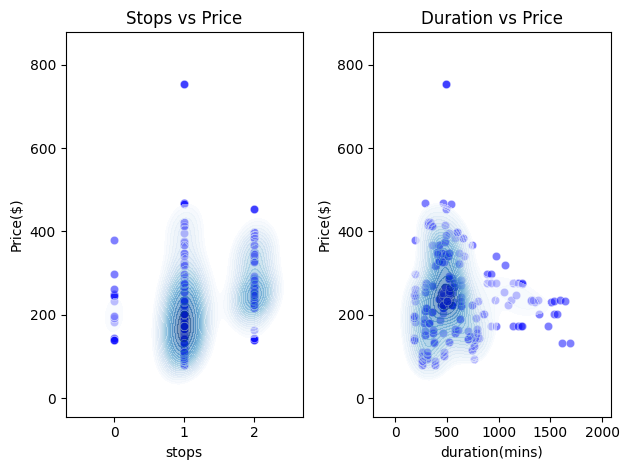

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_copy, x='stops', y='price', alpha=0.5, color='blue')
sns.kdeplot(data=df_copy, x='stops', y='price', cmap='Blues', fill=True, thresh=0.2, levels=20, alpha=0.5)
plt.ylabel('Price($)')
plt.title('Stops vs Price')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_copy, x='duration', y='price', alpha=0.5, color='blue')
sns.kdeplot(data=df_copy, x='duration', y='price', cmap='Blues', fill=True, thresh=0.2, levels=20, alpha=0.5)
plt.ylabel('Price($)')
plt.xlabel('duration(mins)')
plt.title('Duration vs Price')

plt.tight_layout()
plt.show()

- We can see that majority the flights have 1 stop
- Duration for most of the flights(incl. layovers) is 500 mins.
- In these flights, most of them are priced around \$200

Let us see how prices vary as compared to departure and arrival times

In [38]:
df_copy['departure'] = pd.to_datetime(df_copy['departure'])
df_copy['arrival'] = pd.to_datetime(df_copy['arrival'])
df_copy['departure_time'] = df_copy['departure'].dt.time
tick_positions = range(len(df_copy))
tick_labels = df_copy['departure_time'].tolist()

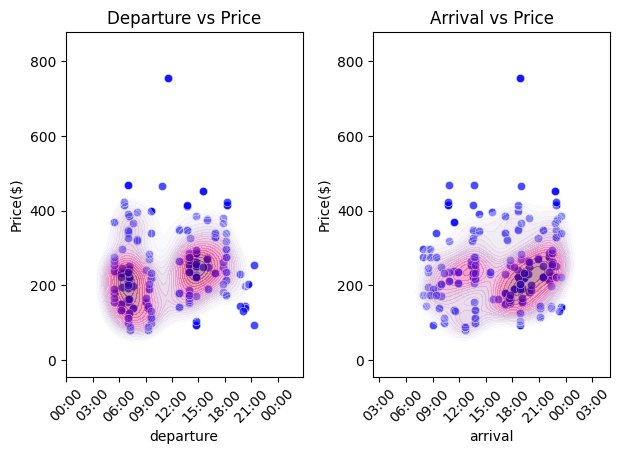

In [39]:
#Converting to datatime format for plotting

from matplotlib.dates import DateFormatter

plt.subplot(1, 2, 1)
sns.scatterplot(data=df_copy, x='departure', y='price', alpha=0.7, color='blue')
sns.kdeplot(data=df_copy, x='departure', y='price', cmap='PuRd', fill=True, thresh=0.2, levels=20, alpha=0.4)
plt.xticks(rotation=45)
plt.ylabel('Price($)')
plt.title('Departure vs Price')

date_format = DateFormatter("%H:%M")
plt.gca().xaxis.set_major_formatter(date_format)

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_copy, x='arrival', y='price', alpha=0.7, color='blue')
sns.kdeplot(data=df_copy, x='arrival', y='price', cmap='PuRd', fill=True, thresh=0.2, levels=20, alpha=0.4)
plt.xticks(rotation=45)

plt.ylabel('Price($)')
plt.title('Arrival vs Price')

plt.tight_layout()

date_format = DateFormatter("%H:%M")
plt.gca().xaxis.set_major_formatter(date_format)

plt.show()

- The most common departure times are around 06:00 and 15:00.
- The prices for these times are around \$200 and \$230 respectively.
- The corresponding arrivals are roughly at 13:00 and 20:00.


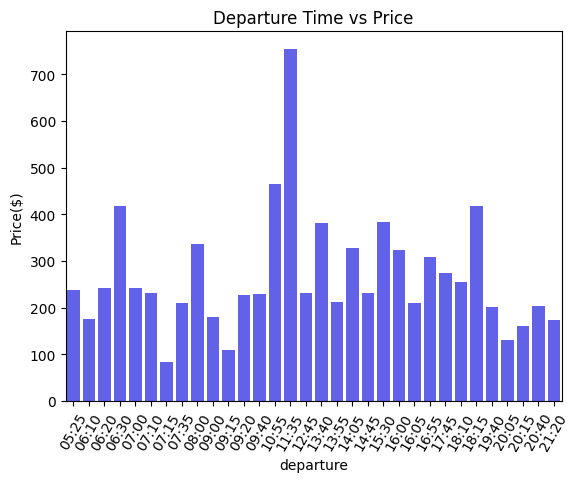

In [40]:
df_copy['departure_time'] = df_copy['departure'].dt.strftime('%H:%M')
df_copy.set_index('departure_time', inplace=True)
df_copy = df_copy.sort_index()
sns.barplot(data=df_copy, y='price', x=df_copy.index, alpha=0.7, color='blue', errorbar=None)

plt.ylabel('Price($)')
plt.xlabel('departure')

plt.title('Departure Time vs Price')

plt.xticks(rotation=60)

plt.show()

- We can see that prices are highest for the 11.35 departure, followed by 10.55 and 18.15.
- In contrast, later timings such as from 20.05 to 06.20 tend to be cheaper.
- This shows that the most comfortable times have the highest prices.
- Also, the late night and early morning prices are quite stable and don't vary sharply, compared to the morning and afternoon timings.

Text(0.5, 1.0, 'Price vs Carriers')

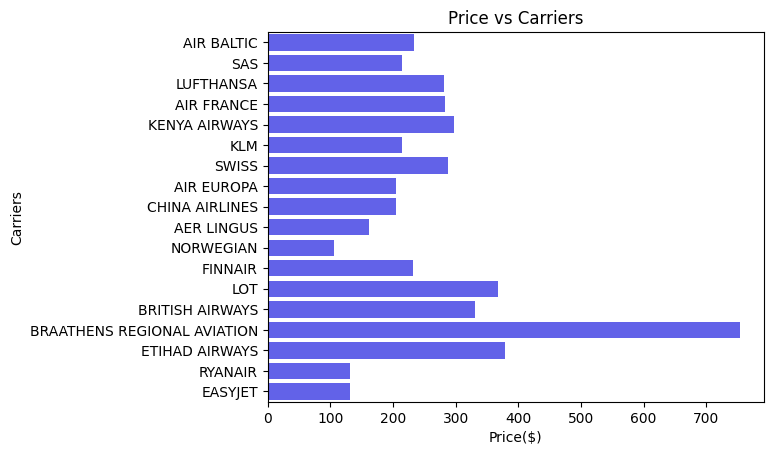

In [42]:
df_copy.reset_index(drop=True, inplace=True)
df2_split = df_copy['carriers'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True).reset_index()
df2_split.columns = ['level_0', 'carriers']

df2_merged = df2_split.merge(df_copy[['price']], left_on='level_0', right_index=True, how='left')

sns.barplot(data=df2_merged, x='price', y='carriers', color='blue', alpha = 0.7, errorbar=None)

plt.xlabel('Price($)')
plt.ylabel('Carriers')
plt.title('Price vs Carriers')

Finally, we see that **Braathens Regional Aviation** tends to have the most expensive flights, while **Norwegian** tends to have the cheapest.

## Step 4: User interaction

In [44]:
usr_min_price = float(input('Enter the min. flight price(in $): '))
usr_max_price = float(input('Enter the max. flight price(in $): '))
usr_duration = int(input('Enter the max. flight duration(in mins): '))
usr_num_stops = int(input('Enter the no. of stops(-1 for any): '))

Enter the min. flight price(in $): 50
Enter the max. flight price(in $): 200
Enter the max. flight duration(in mins): 400
Enter the no. of stops(-1 for any): 2


In [45]:
filtered_entries = df2[
    (df2['price'] >= usr_min_price) &
    (df2['price'] <= usr_max_price) &
    (df2['duration'] <= usr_duration) &
    ((usr_num_stops == -1) | (df2['stops'] == usr_num_stops))
]

In [46]:
avl_carriers = filtered_entries['carriers'].str.split(', ').explode().str.strip().unique()

In [47]:
usr_carrier = input(f'Following carriers are available {avl_carriers}, enter you favorite(-1 to ignore): ')

Following carriers are available [], enter you favorite(-1 to ignore): -1


In [48]:
if(usr_carrier != -1):
  filtered_entries = filtered_entries[
      (filtered_entries['carriers'].str.contains(usr_carrier))
  ]

In [49]:
usr_sort = input('Sort criteria are {stops, duration, departure, arrival}, enter your preferred criteria: ')

Sort criteria are {stops, duration, departure, arrival}, enter your preferred criteria: arrival


In [50]:
filtered_entries = filtered_entries.sort_values(by=usr_sort)

In [51]:
filtered_entries

,layover,stops,duration,departure,arrival,carriers,aircrafts,price,site


In [52]:
usr_pref_time = input("Enter your earliest convenient time of departure (HH:MM): ")
usr_max_time = input("Enter maximum travel time (HH:MM): ")

Enter your earliest convenient time of departure (HH:MM): 10:00
Enter maximum travel time (HH:MM): 06:00


In [53]:
usr_max_time = sum(int(x) * 60 ** i for i, x in enumerate(reversed(usr_max_time.split(':'))))

In [54]:
sorted_dep = df2.sort_values(by='departure')

In [55]:
filtered_dep = sorted_dep[sorted_dep['departure'] >= usr_pref_time]
filtered_dep = filtered_dep[filtered_dep['duration'] <= usr_max_time]

In [56]:
filtered_dep

,layover,stops,duration,departure,arrival,carriers,aircrafts,price,site
181,['1h 10m•MUC'],1,325,12:45,17:10,"LUFTHANSA, LUFTHANSA",[],180.05,booking
17,['1h10m•MUC'],1,325,12:45,17:10,LUFTHANSA,"['Airbus A320neo', 'Airbus A319']",179.00,momondo
108,['1h10m•MUC'],1,325,12:45,17:10,LUFTHANSA,"['Airbus A320neo', 'Airbus A319']",179.00,kayak
78,['2h05m•FRA'],1,355,13:40,18:35,LUFTHANSA,"['Airbus A320 (sharklets)', 'Airbus A321-100/2...",413.00,momondo
164,['2h05m•FRA'],1,355,13:40,18:35,LUFTHANSA,"['Airbus A320 (sharklets)', 'Airbus A321-100/2...",413.00,kayak
205,['2h 05m•FRA'],1,355,13:40,18:35,"LUFTHANSA, LUFTHANSA",[],413.83,booking
183,['1h 05m•AMS'],1,290,13:55,17:45,"AIR FRANCE, AIR FRANCE",[],266.67,booking
174,['1h 05m•AMS'],1,290,13:55,17:45,"KLM, KLM",[],160.14,booking
102,['1h05m•AMS'],1,290,13:55,17:45,KLM,"['Boeing 737-800 (winglets)', 'Boeing 737-800 ...",151.00,kayak
113,['1h05m•AMS'],1,290,13:55,17:45,AIR FRANCE,"['Boeing 737-800 (winglets)', 'Boeing 737-800 ...",255.00,kayak


In [57]:
# Find the cheapest flight
cheapest_flight = filtered_dep.sort_values(by='price').iloc[0]
print(f'''Cheapest flight details:
            Duration - {cheapest_flight.loc['duration']}
            Stop(s) - {cheapest_flight.loc['stops']}
            Layover(s) - {cheapest_flight.loc['layover']}
            Aircraft(s) - {cheapest_flight.loc['aircrafts']}
      ''')

Cheapest flight details:
            Duration - 305
            Stop(s) - 1
            Layover(s) - []
            Aircraft(s) - ['Airbus A320neo', 'Airbus A320-100/200']
      


In [58]:
fastest_flight = filtered_dep.sort_values(by='duration').iloc[0]
print(f'''Fastest flight details:
            Duration - {fastest_flight.loc['duration']}
            Stop(s) - {fastest_flight.loc['stops']}
            Layover(s) - {fastest_flight.loc['layover']}
            Aircraft(s) - {fastest_flight.loc['aircrafts']}
      ''')

Fastest flight details:
            Duration - 185
            Stop(s) - 0
            Layover(s) - []
            Aircraft(s) - ['Airbus A321 (sharklets)']
      
